In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
import json
import torch
import pickle
import itertools

import networkx as nx
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt 
from tqdm import tqdm
from collections import Counter 

sys.path.insert(0, "../")

## Load PlaNet knowledge graph

In [2]:
import knowledge_graph
from knowledge_graph.kg import *

In [3]:
KG = pd.read_pickle('../data/knowledge-graph-31_7_21.pkl')

To check all KG nodes:

In [5]:
print ("total number of nodes", len(KG.nodes()), "\n")

node_type_counts = Counter()
for kgid in KG.nodes():
    node_type_counts.update(list(KG.nodes()[kgid]['ntypes']))

for node_type in sorted(node_type_counts.keys(), key=lambda x: str(x)):
    print(node_type, node_type_counts[node_type])

total number of nodes 330915 

DISEASE 5751
DRUG 14300
DRUGONT 4825
FUNCTION 28734
PRIMARY_OUTCOME 3048
PROTEIN 17660
SIDE_EFFECT 24335
SIDE_EFFECT_CAT 28
TRIAL_ARM 205809
UMLS 30913


To check all KG edges:

In [6]:
print ("total number of edges", len(KG.edges.data()), "\n")

edge_type_count = Counter()
for edge in tqdm(KG.edges.data()):
    head, tail, meta = edge
    for h in KG.nodes()[head]['ntypes']:
        for t in KG.nodes()[tail]['ntypes']:
            if str(h)=='TRIAL_ARM' and str(t)=='UMLS':
                edge_type_count.update([f"{h}-{t}-{meta['relation']}"])
            else:
                edge_type_count.update([f"{h}-{t}"])

for edge_type in sorted(edge_type_count.keys(), key=lambda x: str(x)):
    print(edge_type, edge_type_count[edge_type])

total number of edges 13928443 



100%|█████████████████████████████████████████| 13928443/13928443 [01:33<00:00, 148315.81it/s]

DISEASE-DISEASE 17510
DISEASE-FUNCTION 526
DISEASE-PROTEIN 32966
DISEASE-UMLS 32099
DRUG-DISEASE 896
DRUG-DRUG 338
DRUG-DRUGONT 133661
DRUG-FUNCTION 26142
DRUG-PROTEIN 22062
DRUG-UMLS 14176
DRUGONT-DRUGONT 4824
FUNCTION-DISEASE 298
FUNCTION-FUNCTION 67118
FUNCTION-PROTEIN 313
FUNCTION-UMLS 4505
PROTEIN-DISEASE 174
PROTEIN-FUNCTION 39605
PROTEIN-PROTEIN 387626
PROTEIN-UMLS 1119
SIDE_EFFECT-PROTEIN 879
SIDE_EFFECT-SIDE_EFFECT 35673
TRIAL_ARM-DISEASE 2360695
TRIAL_ARM-DRUG 874881
TRIAL_ARM-FUNCTION 172438
TRIAL_ARM-PRIMARY_OUTCOME 911260
TRIAL_ARM-SIDE_EFFECT 2728813
TRIAL_ARM-SIDE_EFFECT_CAT 734443
TRIAL_ARM-UMLS-arm_tests_drug 186114
TRIAL_ARM-UMLS-eligibility-exclusion 5370161
TRIAL_ARM-UMLS-eligibility-inclusion 2778103
TRIAL_ARM-UMLS-study-disease 240115
UMLS-DISEASE 19539
UMLS-DRUG 643
UMLS-DRUGONT 16499
UMLS-FUNCTION 15769
UMLS-PROTEIN 38618
UMLS-UMLS 92744


## Load clinical trials data

In [9]:
trial_data = pd.read_pickle('../data/graph/unique_arms.pkl')
trial_data.head()

,trial,drugs,diseases,outcomes,incl_criteria,excl_criteria,has_results
node_id,,,,,,,
KG00125078,NCT02929316,"(KG00018929,)","(KG00000882,)",{},"{KG00073991, KG00001018, KG00087715, KG0007520...","{KG00010624, KG00092647, KG00079066, KG0000113...",False
KG00125079,NCT02920359,"(KG00010582,)","(KG00005750,)","{KG00122979, KG00122080, KG00122031}","{KG00079766, KG00096437, KG00091304, KG0009582...","{KG00075948, KG00092647, KG00087775, KG0007541...",False
KG00125080,NCT02920905,"(KG00010846,)","(KG00002650,)","{KG00122404, KG00122845}",{},"{KG00001178, KG00003011, KG00097009, KG0000052...",False
KG00125081,NCT02920905,"(KG00010846, KG00024629)","(KG00002650,)","{KG00122404, KG00122845}",{},"{KG00001178, KG00003011, KG00097009, KG0000052...",False
KG00125082,NCT02920905,"(KG00010846, KG00012048, KG00024629)","(KG00002650,)","{KG00122404, KG00122845}",{},"{KG00001178, KG00003011, KG00097009, KG0000052...",False


## Visualize PlaNet embeddings

In [3]:
from anndata import AnnData, read_csv
import scanpy as sc

In [6]:
emb_df = pd.read_pickle('../data/analysis/trial_embeddings/trial_embeddings_3u7di6ag.pkl')
emb = AnnData(np.vstack(emb_df['encoder-embs'].values))
emb.obs_names = emb_df['node_id'].values
emb.obs['trial'] = emb_df['trial'].values
emb.obs['dis_grp_major'] = pd.Categorical(pkl.load(open('../data/analysis/trial_embeddings/disgrp.pkl', 'rb')))

         Falling back to preprocessing with `sc.pp.pca` and default params.


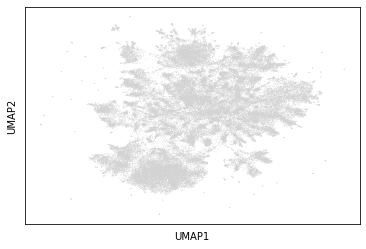

In [8]:
sc.pp.neighbors(emb, n_neighbors=15)
sc.tl.umap(emb)
sc.pl.umap(emb)

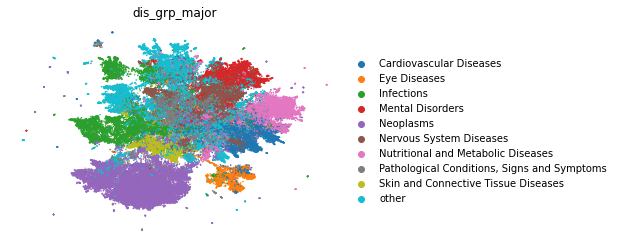

In [11]:
fig = sc.pl.umap(emb, color = ['dis_grp_major'], size=10, return_fig=True)
plt.axis('off')
plt.show()

## Run PlaNet models

In [13]:
from utils.demo_utils import load_model_and_data, model_inference
from gcn_models.utils import set_seed
from gcn_models.evaluator import Evaluator
set_seed(24)

First, load the model and prediction task dataset:

In [4]:
(dataset, tasks), encoder, bert_encoder, model, args, runner = load_model_and_data('../data/models/safety_model_1xekl810/ckpt.pt')

Adding infer nodes and edges
Reading train triples....
False
Finished. Read 3388945 train triples.
Reading valid triples....
False
Finished. Read 188264 valid triples.
Reading test triples....
False
Finished. Read 188297 test triples.
(205809, 786)
TRIAL_ARM          205809
PROTEIN             15787
DRUG                14299
UMLS                 7651
DISEASE              5751
PRIMARY_OUTCOME      3048
Name: etype, dtype: int64

Final:
TRIAL_ARM          86899
PROTEIN            15787
DRUG               12133
UMLS                7645
DISEASE             5751
PRIMARY_OUTCOME     2960
Name: etype, dtype: int64
         trial        kgid
0  NCT00000134  KG00251195
1  NCT00000134  KG00251197
2  NCT00000134  KG00251196
3  NCT00000136  KG00249524
4  NCT00000142  KG00250283
Total AE idx: 1
Labels:  (array([False,  True]), array([20448,  6166]))
Task: binary_or, Subtasks: 1
task_y.shape torch.Size([26614, 1])
enrollment_filter 20
len(self.df) 26614
len(self.df) 21857
train_end_year 2015.5833333

0it [00:00, ?it/s]

batch_size: 128
gradient_accumulation_steps (for training): 1
effective batch_size (for training): 128
layer_sizes [-1, -1, -1]


To run model inference on the test set:

In [5]:
y_test_true, y_test_pred, x_test = model_inference(runner, mode='test') 
print ('y_test_pred.size()', y_test_pred.size(), 'y_test_true.size()', y_test_true.size())

100%|█████████████████████████████████████████████████████████| 13/13 [00:21<00:00,  1.58s/it]

y_test_pred.size() torch.Size([3202, 1]) y_test_true.size() torch.Size([3202, 1])


To evaluate the model outputs (`y_test_pred`) against the labels (`y_test_true`):

In [6]:
evaluate_fn = Evaluator.rank_evaluate
performance_metrics = evaluate_fn(y_score=y_test_pred, labels=y_test_true, num_repeats=10)

print ("ae_roc_auc", performance_metrics['ae_roc_auc'])
print ("ae_auprc", performance_metrics['ae_auprc'])
print ("ae_balanced_auprc", performance_metrics['ae_balanced_auprc'])


100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.25it/s]

ae_roc_auc 0.808921965918537
ae_auprc 0.5986913113431984
ae_balanced_auprc 0.828738368641955
